In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
full_df = pd.read_hdf('race1.hd5')
df2 = full_df['GBR'].copy()

In [3]:
ser = pd.Series([0,5,10,20])
print ser
print ser.shift(1)

0     0
1     5
2    10
3    20
dtype: int64
0     NaN
1     0.0
2     5.0
3    10.0
dtype: float64


In [4]:
def correct_angle(ser):
    wd_df = pd.DataFrame({'cwd': ser.copy()})
    wd_df['low_5s'] = wd_df['cwd'] < 5 #Creates a boolean array that is false in every position where 'cwd' is less than 5
    wd_df['high_355s'] = wd_df['cwd'] > 355 #Creates a boolean array that is false in every position where 'cwd' is greater than 355
    #shift(-1) moves every element of low_5s back one position in the array
    #low_to_high is the logical AND of the two arrays
    wd_df['low_to_high'] = wd_df['low_5s'].shift(-1) & wd_df['high_355s'] 
    wd_df['high_to_low'] = wd_df['high_355s'].shift(-1) & wd_df['low_5s']
    #create a series in the wd_df that has every position set to 0
    wd_df['cwd_correction_dir'] = 0
    #at every position where 'high_to_low' is True, set cwd_correction_dir to -1
    wd_df.loc[wd_df['high_to_low'], 'cwd_correction_dir'] = -1
    #at every position where 'low_to_high' is True, set cwd_correction_dir to 1
    wd_df.loc[wd_df['low_to_high'], 'cwd_correction_dir'] = 1
    #take the cumulative sum of cwd_correction_dir and multiply each position by 360
    wd_df['cwd_correction'] = wd_df['cwd_correction_dir'].cumsum() * 360
    #add cwd and cwd_correction at each point in the the two arrays
    wd_df['corrected'] = wd_df['cwd'] + wd_df['cwd_correction']
    return wd_df['corrected'], wd_df['cwd_correction']


In [5]:
df2['CWD'] = df2['CourseWindDirection']
df2['C_CWD'], wind_correction = correct_angle(df2['CourseWindDirection'])
df2['C_COG'], c_correction = correct_angle(df2['COG'])

df2['CB_CWD'] =  df2['CWD'] - c_correction # coursewind - course correction
df2['CW_COG'] = df2['COG'] - wind_correction
df2['WC_DIFF'] = (df2['CWD'] - df2['COG']) #Wind Course difference
#create a series named WC_DIFF180 that is the elementwise modulo 180 of WC_DIFF
df2['WC_DIFF180'] = df2['WC_DIFF'] % 180

In [6]:
# every timestamp where WC_DIFF180 is less than 1
tacks = df2[df2['WC_DIFF180'] <1].index.values
tacks

array(['2017-05-09T10:50:21.600000000-0400',
       '2017-05-09T10:51:05.000000000-0400',
       '2017-05-09T10:53:41.000000000-0400',
       '2017-05-09T10:53:58.000000000-0400',
       '2017-05-09T10:53:58.200000000-0400',
       '2017-05-09T10:54:27.400000000-0400',
       '2017-05-09T10:59:28.800000000-0400',
       '2017-05-09T11:01:08.800000000-0400',
       '2017-05-09T11:08:24.000000000-0400',
       '2017-05-09T11:12:06.800000000-0400',
       '2017-05-09T11:14:23.400000000-0400',
       '2017-05-09T11:36:06.200000000-0400',
       '2017-05-09T11:38:51.400000000-0400'], dtype='datetime64[ns]')

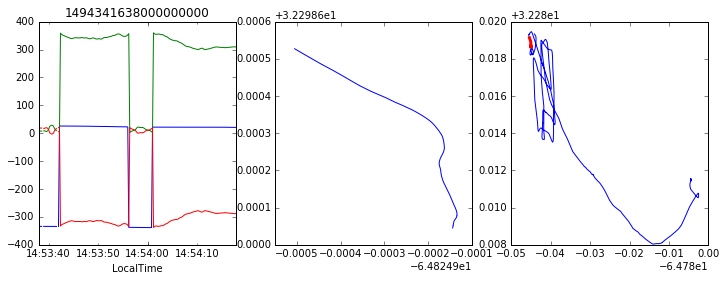

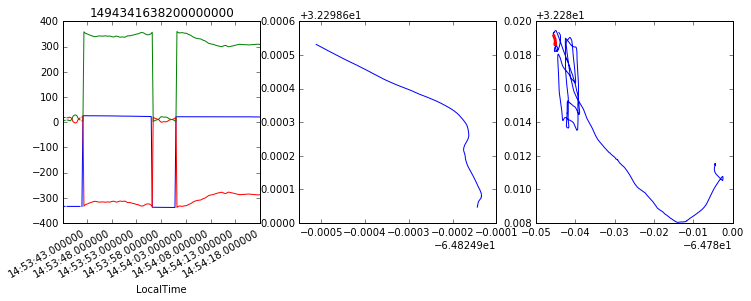

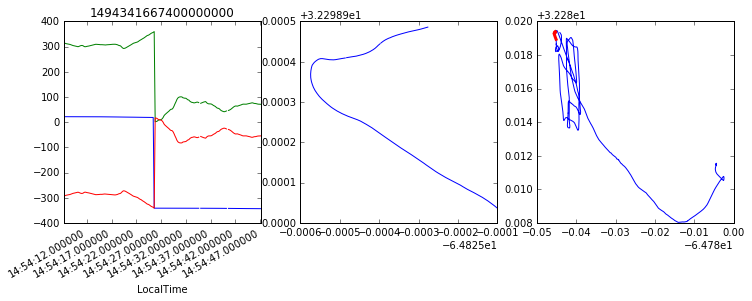

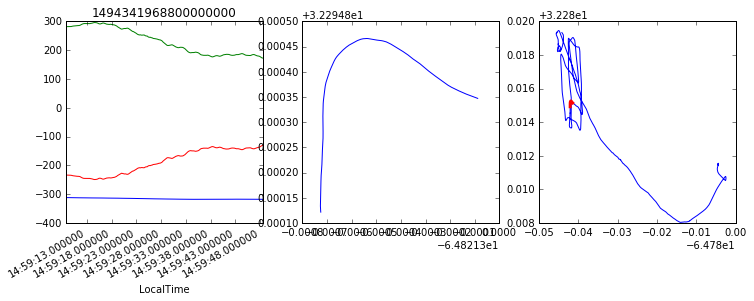

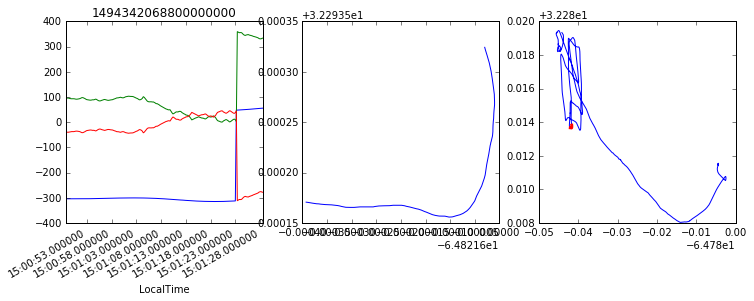

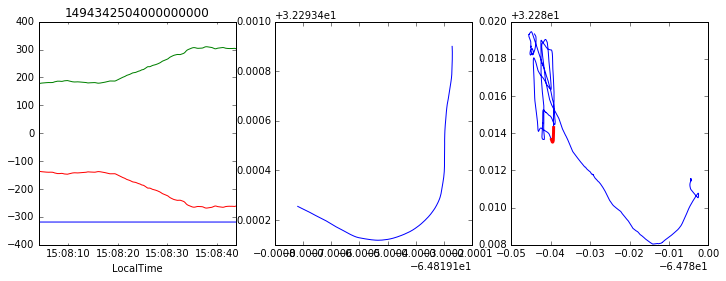

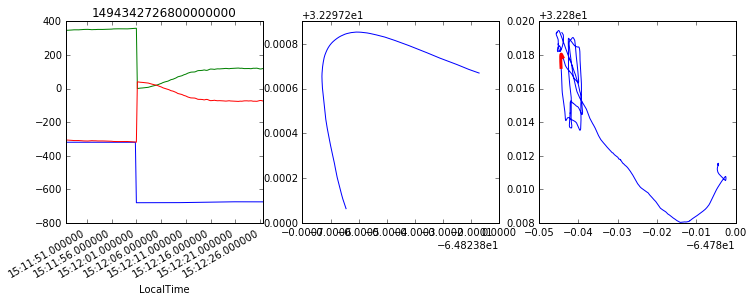

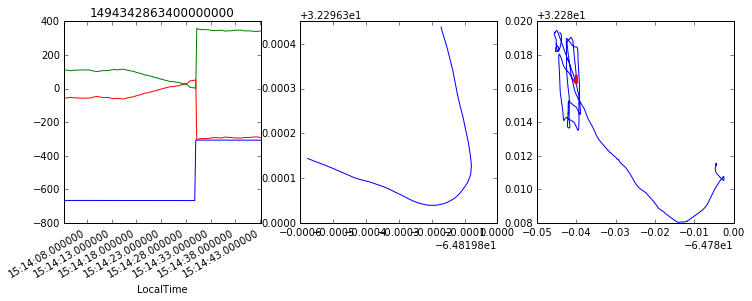

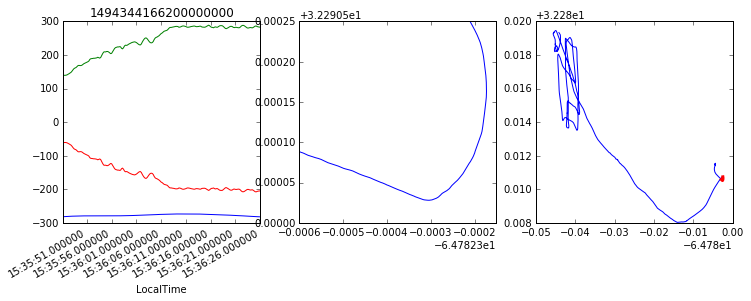

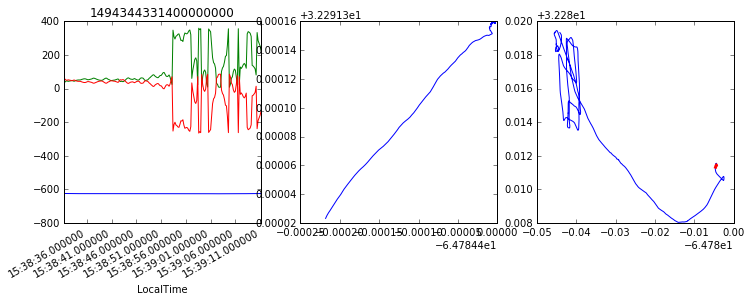

In [7]:
# this produces a series of plots of tacks (or gybes).  On each row the left plot shows COG and WindDirection based readings
# the middle plot shows just the LAT/LONG plot of the tack
# the right plot shows the Lat/Long plot of the whole race with the tack highlighted in context as a thicker red line
for tstamp in tacks[3:]:

    t_idx = df2.index.get_loc(tstamp)
    window_width = 100
    start, end = t_idx - window_width, t_idx + window_width
    df3 = df2.ix[start:end]
    fig, ax = plt.subplots(ncols=3, figsize=(12,4))
    ax1, ax2, ax3 = ax
    
    df3.CB_CWD.plot(title="%d" % tstamp, ax=ax1)
    df3.CW_COG.plot(color='green', ax=ax1)
    df3.WC_DIFF.plot(color='red', ax=ax1)
    #plt.figure()
    ax2.plot(df3.Lon, df3.Lat)

    ax3.plot(df2.Lon, df2.Lat, color='blue')
    ax3.plot(df3.Lon, df3.Lat, color='red', linewidth=3.0)
    
    #plt.figure()